In [1]:
import matplotlib.pyplot as plt
import os
import torch 
from torch.utils.data import DataLoader
import json
import sys
import torch

sys.path.append("src")
os.chdir('/home/george-vengrovski/Documents/projects/tweety_bert_paper')

from data_class import CollateFunction
from utils import load_model

weights_path = "experiments/LLB16_Whisperseg_NoNormNoThresholding/saved_weights/model_step_21000.pth"
config_path = "experiments/LLB16_Whisperseg_NoNormNoThresholding/config.json"

tweety_bert_model = load_model(config_path, weights_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Data Class

In [2]:
from torch.utils.data import DataLoader
from data_class import SongDataSet_Image, deterimine_number_unique_classes

train_dir = "/home/george-vengrovski/Documents/data/llb16_no_threshold_no_norm_train"
test_dir = "/home/george-vengrovski/Documents/data/llb16_no_threshold_no_norm_test"

num_classes = deterimine_number_unique_classes(train_dir)

train_dataset = SongDataSet_Image(train_dir, num_classes=num_classes, infinite_loader=False)
test_dataset = SongDataSet_Image(test_dir, num_classes=num_classes, infinite_loader=False)

collate_fn = CollateFunction(segment_length=1000)  # Adjust the segment length if needed

train_loader = DataLoader(train_dataset, batch_size=48, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=48, shuffle=True, collate_fn=collate_fn)

## Define Linear Classifier and Train

In [3]:
from linear_probe import LinearProbeModel, LinearProbeTrainer

classifier_model = LinearProbeModel(num_classes=num_classes, model_type="neural_net", model=tweety_bert_model, freeze_layers=True, layer_num=-1, layer_id="feed_forward_output", TweetyBERT_readout_dims=196, classifier_type="linear_probe")
classifier_model = classifier_model.to(device)

Step 50: Train Loss 0.2011 FER = 13.80%, Val Loss = 0.5293
Step 100: Train Loss 0.1951 FER = 12.62%, Val Loss = 0.4345
Step 150: Train Loss 0.2604 FER = 6.84%, Val Loss = 0.2246
Step 200: Train Loss 0.3092 FER = 7.01%, Val Loss = 0.2006
Step 250: Train Loss 0.2700 FER = 11.18%, Val Loss = 0.3485
Step 300: Train Loss 0.1697 FER = 10.00%, Val Loss = 0.4399
Step 350: Train Loss 0.2810 FER = 4.62%, Val Loss = 0.1399
Step 400: Train Loss 0.2354 FER = 9.62%, Val Loss = 0.5262
Step 450: Train Loss 0.1716 FER = 6.84%, Val Loss = 0.2638
Step 500: Train Loss 0.2335 FER = 6.37%, Val Loss = 0.1976


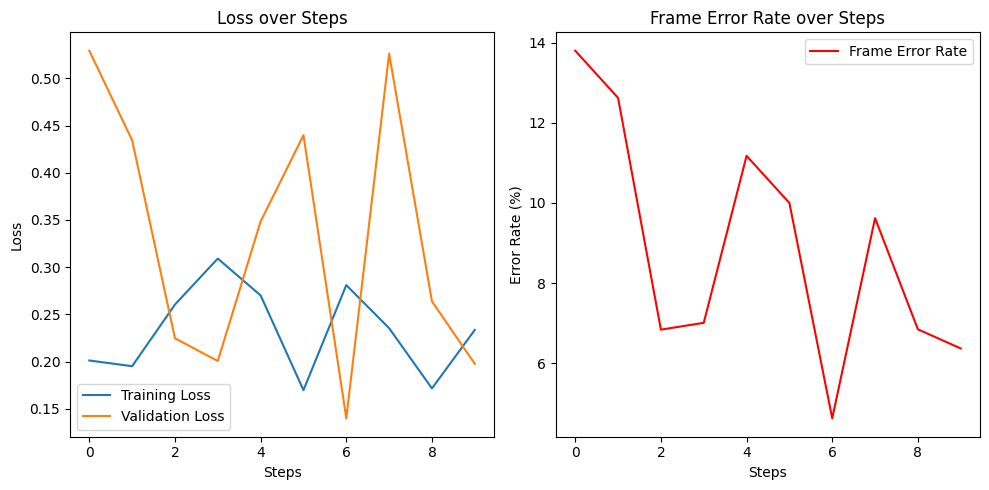

In [4]:
trainer = LinearProbeTrainer(model=classifier_model, train_loader=train_loader, test_loader=test_loader, device=device, lr=1e-4, plotting=True, batches_per_eval=250, desired_total_batches=5000, patience=4)
weight_differences = trainer.train()

## Analyze

In [5]:
from linear_probe import ModelEvaluator

# Initialize the ModelEvaluator with the filter_unseen_classes feature
evaluator = ModelEvaluator(model=classifier_model, 
                           test_loader=test_loader, 
                           num_classes=num_classes,  # Assuming there are 21 possible classes
                           device='cuda:0',  # Use CUDA if available
                           filter_unseen_classes=True,  # Enable filtering based on training set classes
                           train_dir=train_dir)  # Path to the training dataset directory

# Perform model validation with multiple passes
class_frame_error_rates, total_frame_error_rate = evaluator.evalulate_model(num_passes=1, max_batches=1250)

# Save the results to a specified directory, for example 'evaluation_results'
evaluator.save_results(class_frame_error_rates, total_frame_error_rate, 'results/')
